In [ ]:
# Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Overview

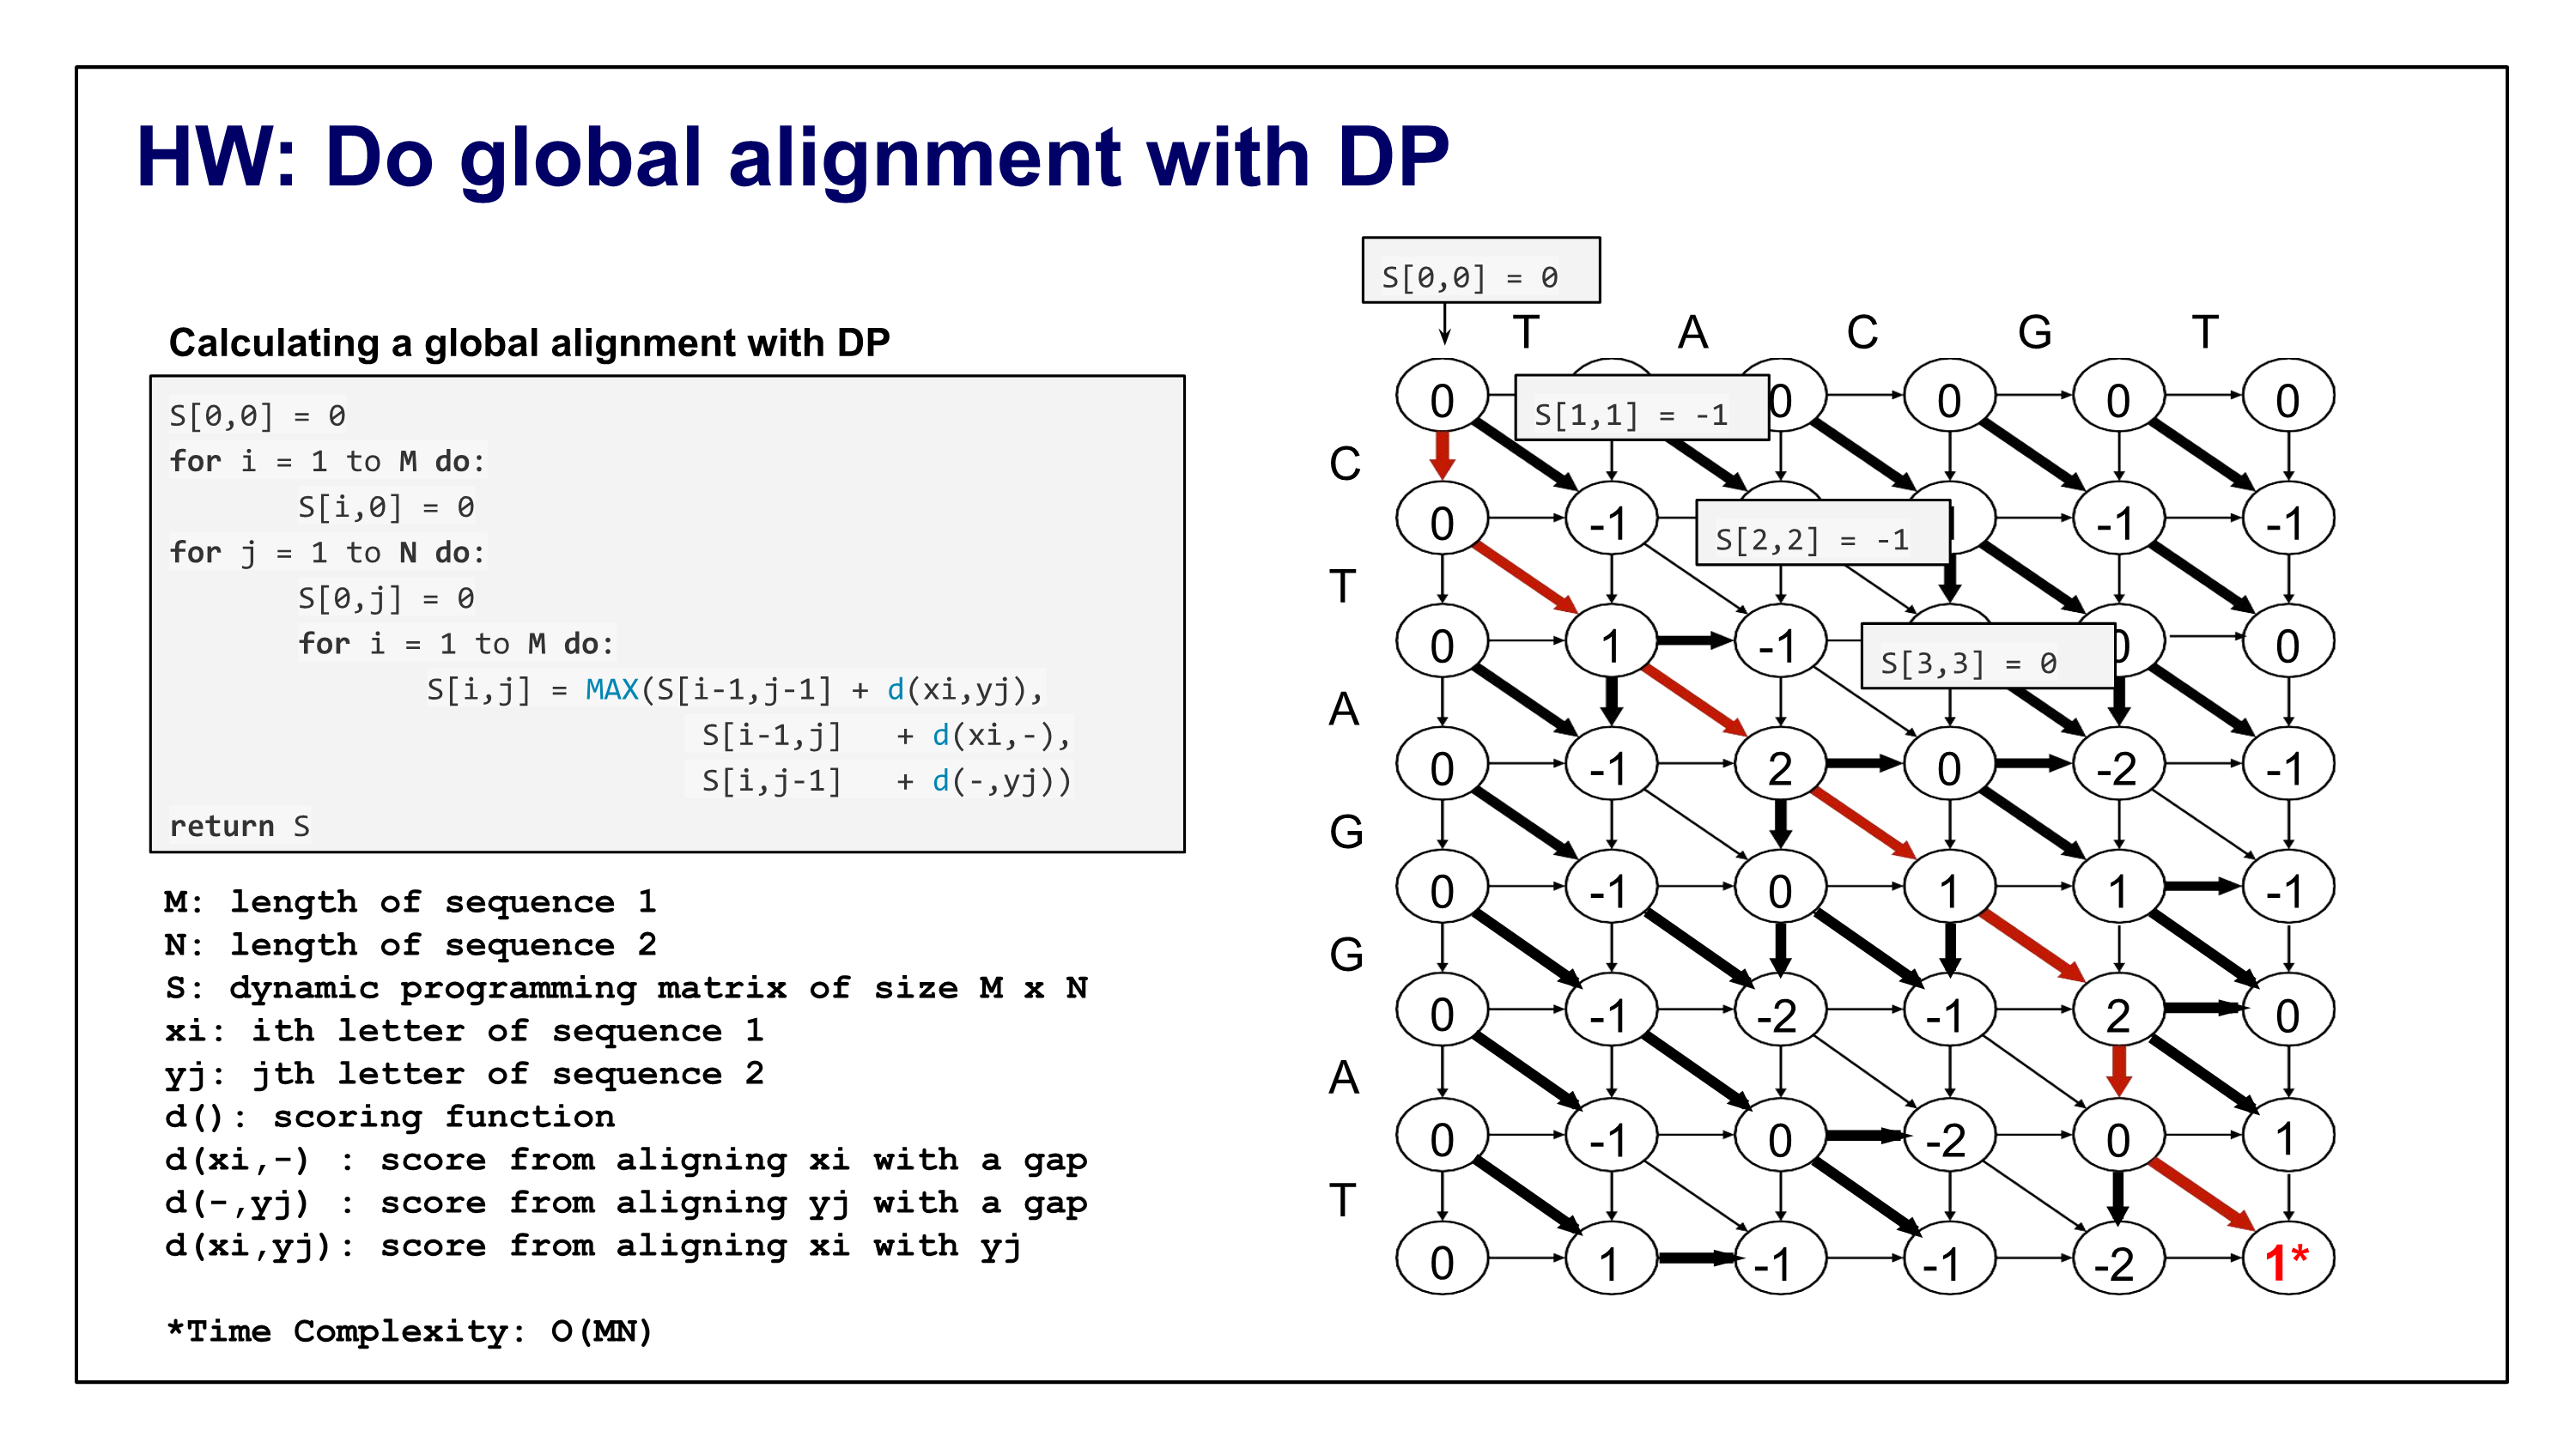

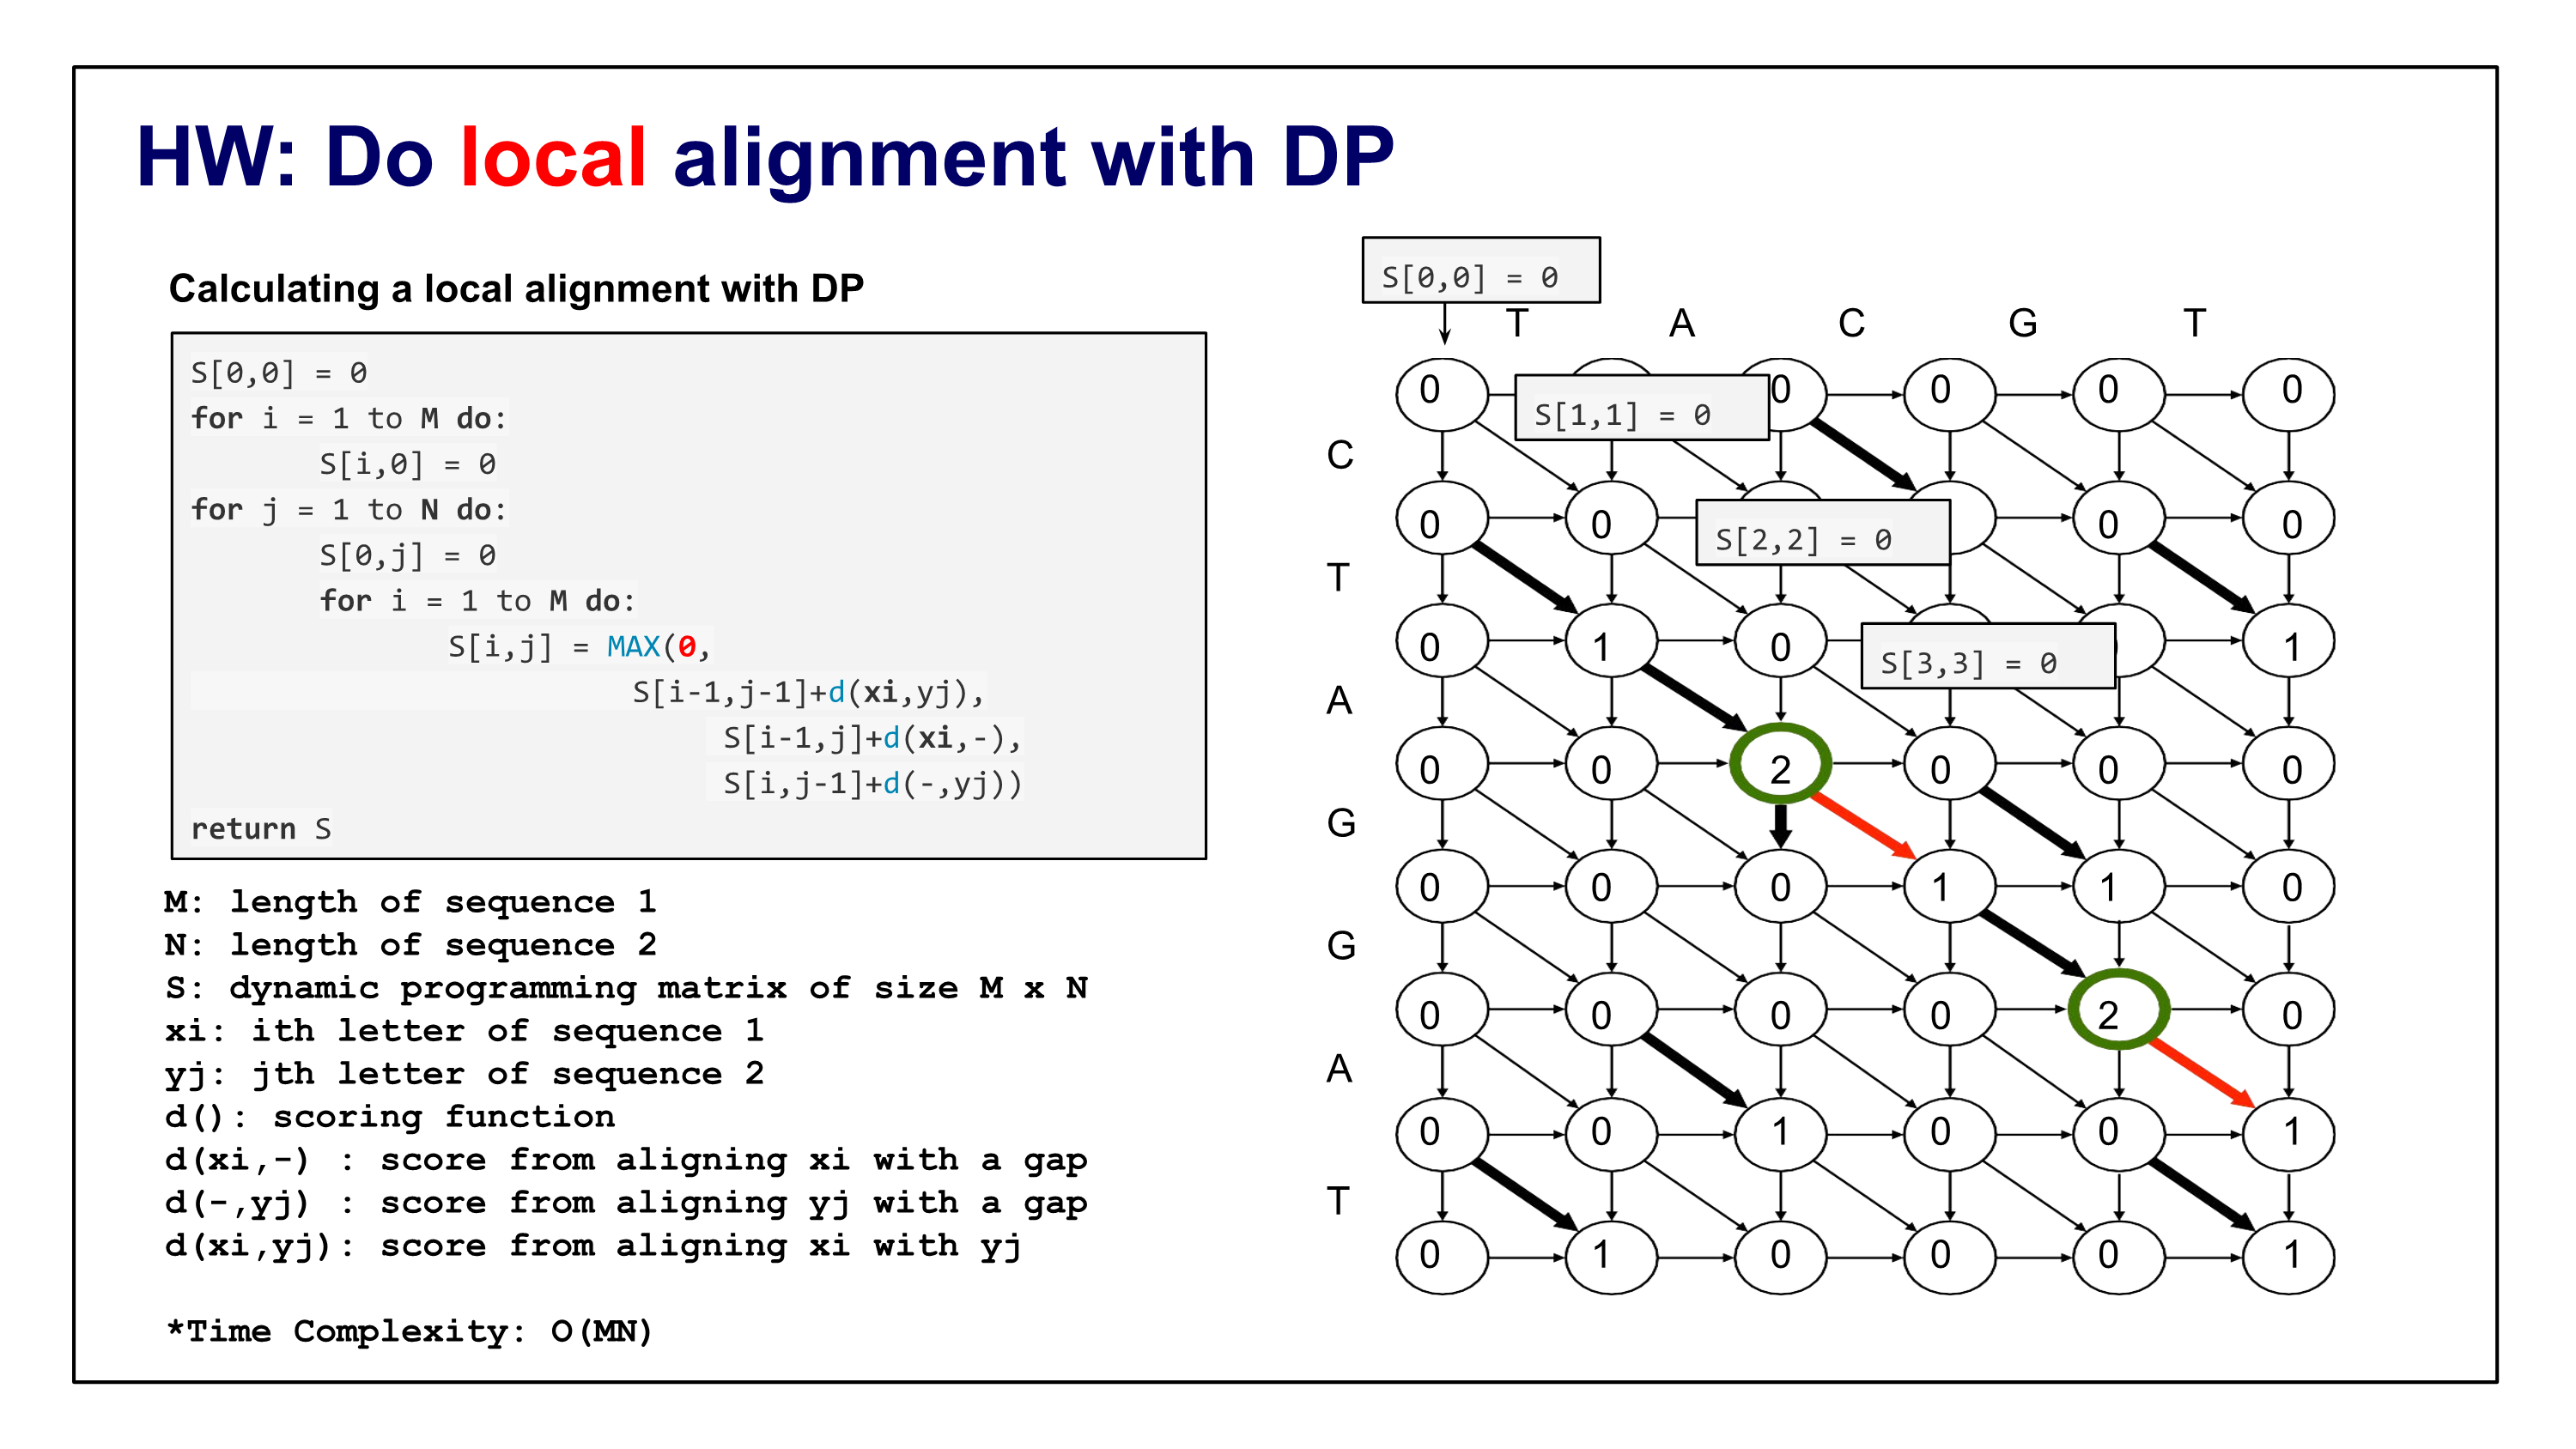

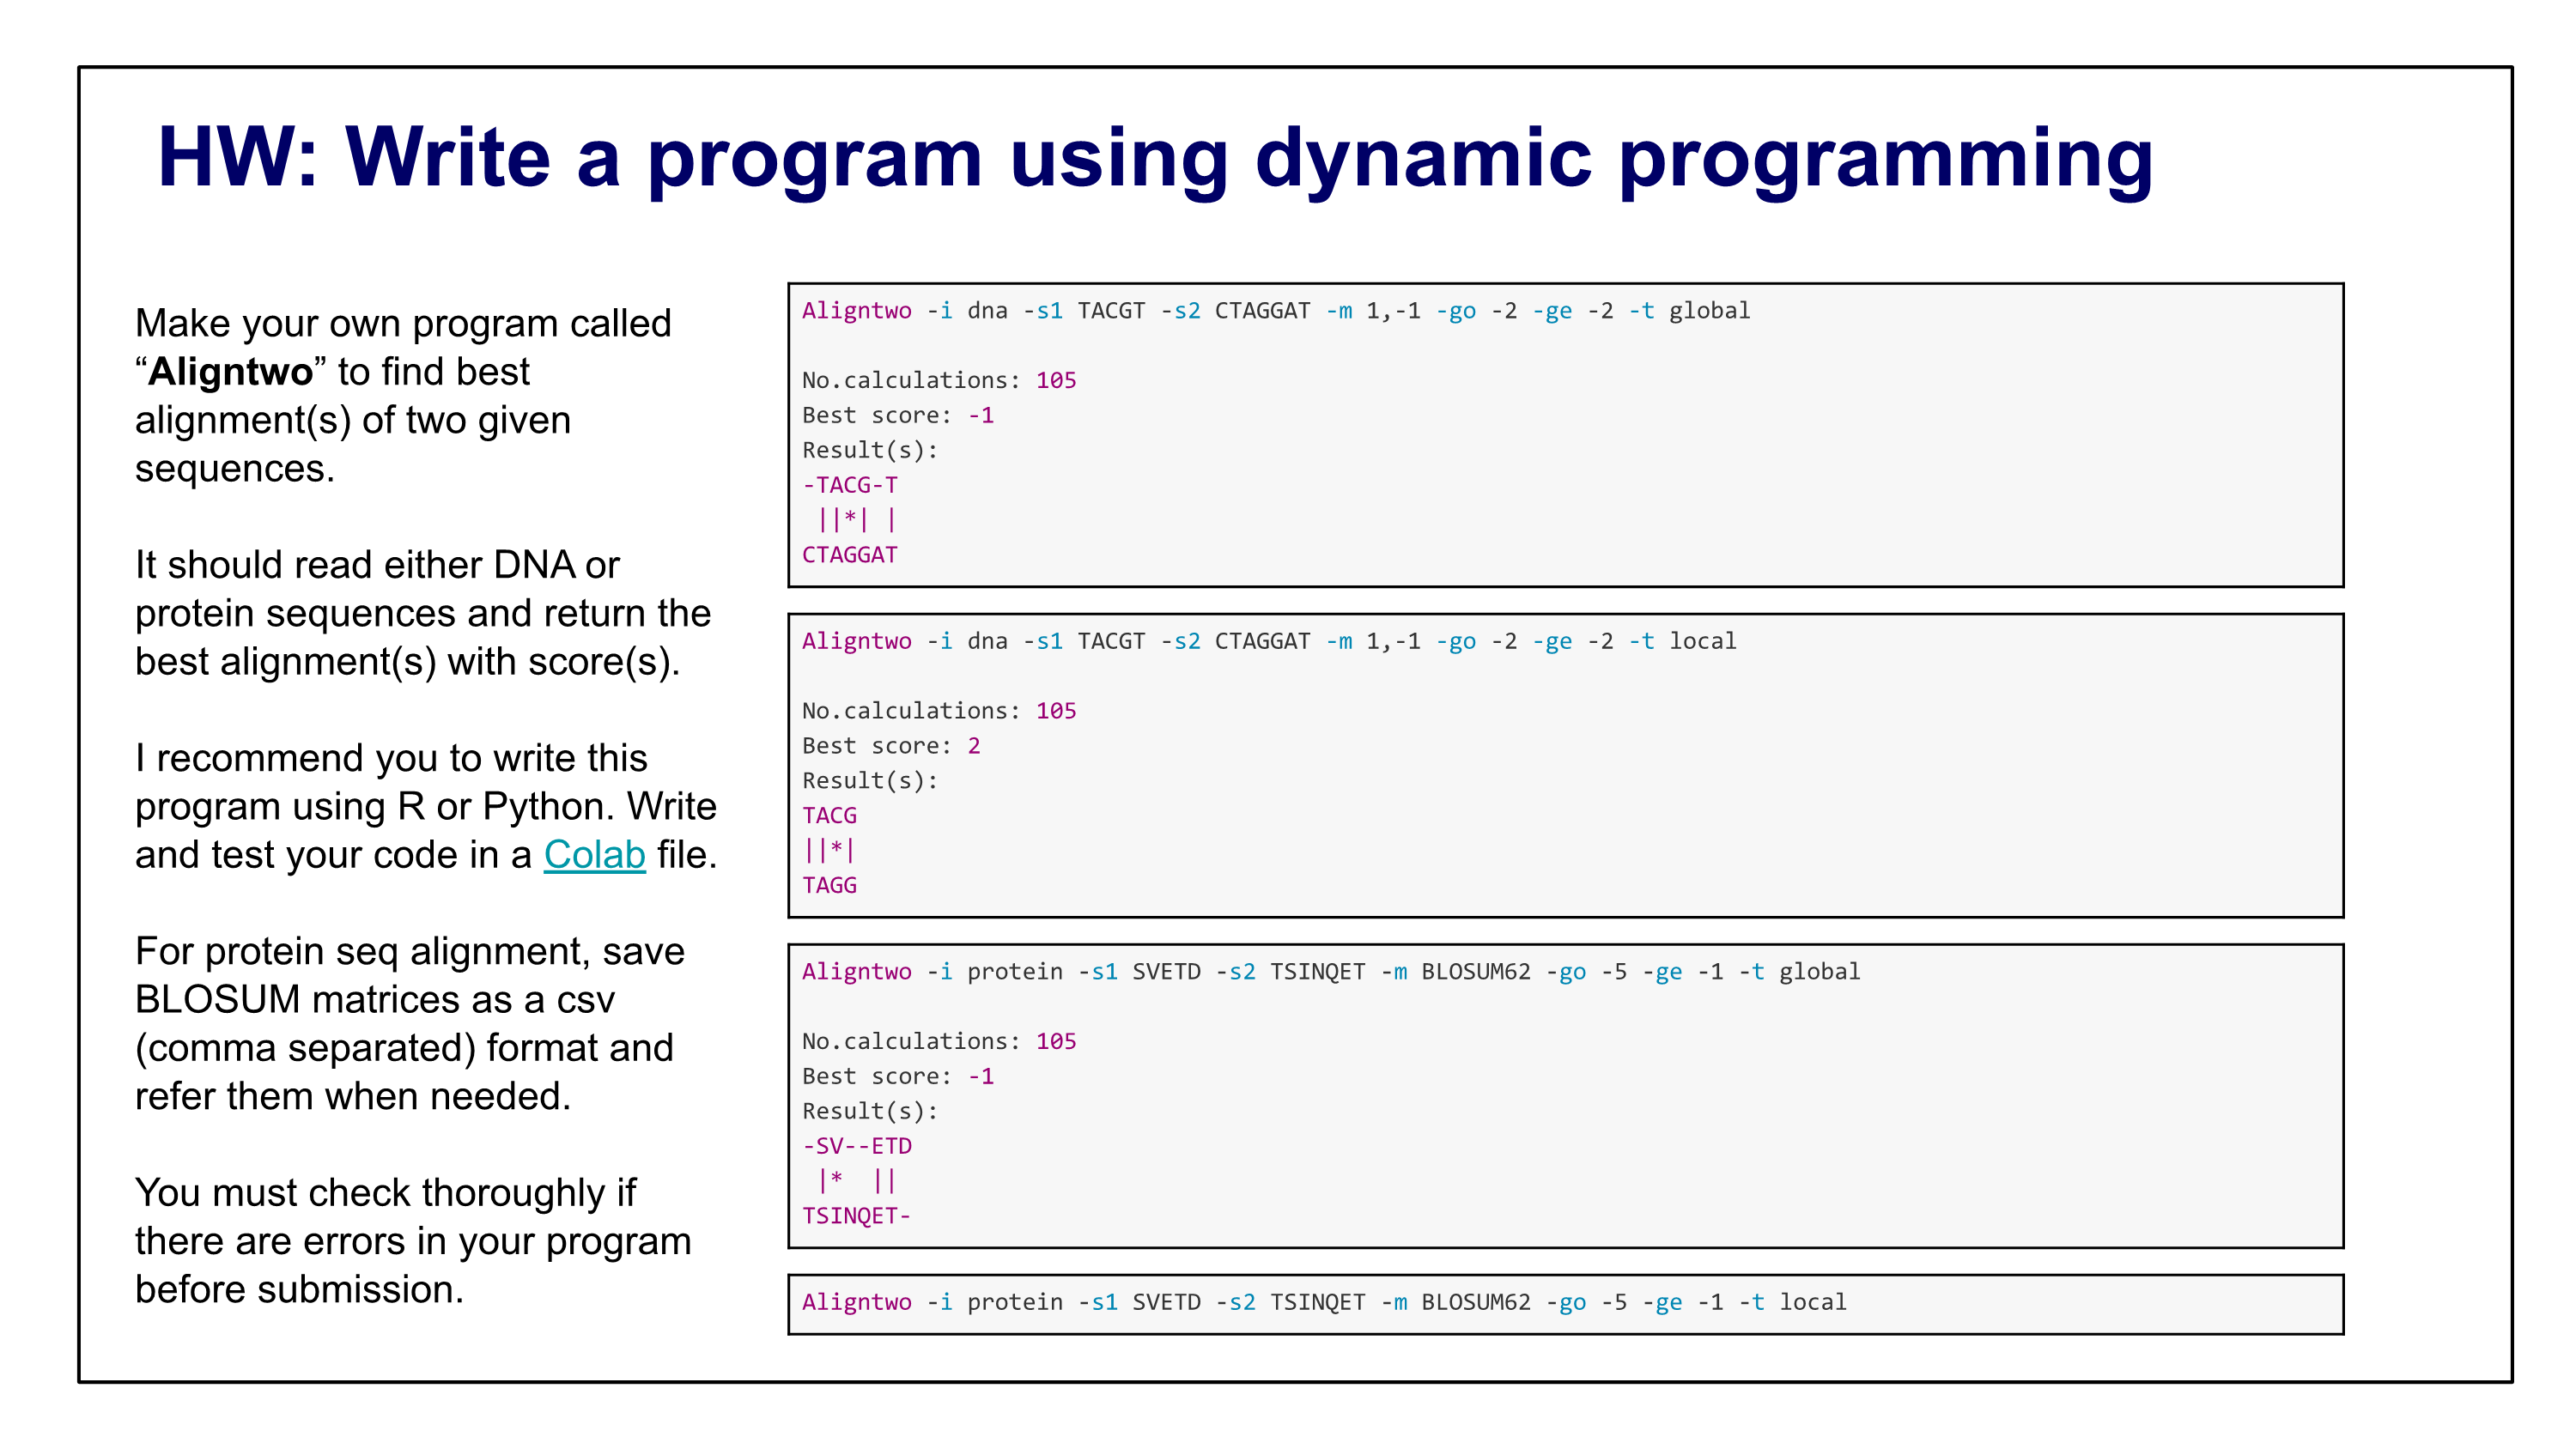

# Dynamic programming을 사용하여 Alignment 알고리즘 구현하기

In [ ]:
!pip install blosum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import blosum as bl

## DNA alignment

In [ ]:
def DNA_alignment(S, seq1_list, seq2_list, scoring_method, go, ge, align_type):
    scoring_method = scoring_method.split(",")
    match_score = int(scoring_method[0])
    mismatch_score = int(scoring_method[1])

    m, n = len(seq1_list)-1, len(seq2_list)-1

    for j in range(1, n+1):
        for i in range(1, m+1):
            score = 0
            if seq1_list[i] == seq2_list[j]:
                score = S[j-1, i-1] + match_score
            else:
                score = S[j-1, i-1] + mismatch_score
            
            max_num = max([S[j-1, i], S[j, i-1]])
            if max_num + go > score: # ARK: what about gap extension?
                S[j, i] = max_num + go
            else:
                S[j, i] = score
    
    # backtracking
    result_seq1 = []
    result_check = []
    result_seq2 = []

    # global
    if align_type == 'global':
        j, i = n, m
        while i != 0 or j != 0:
            if i == 0 or j == 0:
                if j != 0:
                    result_seq1.append('-')
                    result_seq2.append(seq2_list[j])
                    j = j-1
                else:
                    result_seq1.append(seq1_list[i])
                    result_seq2.append('-')
                    i = i-1
                result_check.append(' ')
            elif S[j-1, i] - S[j, i] == 2:
                result_seq1.append('-')
                result_seq2.append(seq2_list[j])
                result_check.append(' ')
                j = j-1
            elif S[j, i-1] - S[j, i] == 2:
                result_seq1.append(seq1_list[i])
                result_seq2.append('-')
                result_check.append(' ')
                i = i-1
            else:
                if seq1_list[i] == seq2_list[j]:
                    result_check.append('|')
                else:
                    result_check.append('*')
                result_seq1.append(seq1_list[i])
                result_seq2.append(seq2_list[j])
                j, i = j-1, i-1

        best_score = S[n, m]
    
    # local
    elif align_type == 'local':
        S[S < 0] = 0
        best_score = np.max(S)
        index = np.where(S == best_score)
        j, i = index[0][-1], index[1][-1]

        while i != 0 and j != 0:
            if seq1_list[i] == seq2_list[j]:
                result_check.append('|')
            else:
                result_check.append('*')
            result_seq1.append(seq1_list[i])
            result_seq2.append(seq2_list[j])
            j, i = j-1, i-1

        if result_check[-1] == '*':
            for lst in [result_seq1, result_check, result_seq2]:
                lst.pop()

    print("No.calculations:", len(seq1)*len(seq2)*3)
    print("Best score:", best_score)
    print("Result(s):")
    for lst in [result_seq1, result_check, result_seq2]:
        print(''.join(reversed(lst)))

## Protein alignment

In [ ]:
def protein_alignment(S, seq1_list, seq2_list, scoring_method, go, ge, align_type):
    scoring_method = 'BLOSUM62'

    if scoring_method == 'BLOSUM45':
        mat = bl.BLOSUM(45)
    elif scoring_method == 'BLOSUM62':
        mat = bl.BLOSUM(62)
    elif scoring_method == 'BLOSUM80':
        mat = bl.BLOSUM(80)
    
    m, n = len(seq1_list)-1, len(seq2_list)-1

    # stack direction_arr 만들기
    direction_arr = np.full((n+1, m+1), 'blank')
    for j in range(1, n+1):
        for i in range(1, m+1):
            score = S[j-1, i-1] + mat[seq1_list[i]+seq2_list[j]]
            direction_arr[j, i] = 'diagonal'

            if direction_arr[j-1, i] == 'down' or direction_arr[j, i-1] == 'right':
                if direction_arr[j-1, i] == 'down' and S[j-1, i] + ge > score:
                    score = S[j-1, i] + ge
                    direction_arr[j, i] = 'down'
                if direction_arr[j, i-1] == 'right' and S[j, i-1] + ge > score:
                    score = S[j, i-1] + ge
                    direction_arr[j, i] = 'right'
            else:
                if S[j-1, i] + go > score:
                    score = S[j-1, i] + go
                    direction_arr[j, i] = 'down'
                if S[j, i-1] + go > score:
                    score = S[j, i-1] + go
                    direction_arr[j, i] = 'right'

            S[j, i] = score

    result_seq1 = []
    result_check = []
    result_seq2 = []

    # global
    if align_type == 'global':
        j, i = n, m
        while i != 0 or j != 0:
            if i == 0 or j == 0:
                if j != 0:
                    result_seq1.append('-')
                    result_seq2.append(seq2_list[j])
                    j = j-1
                else:
                    result_seq1.append(seq1_list[i])
                    result_seq2.append('-')
                    i = i-1
                result_check.append(' ')
            # gap
            elif direction_arr[j, i] == 'down':
                result_seq1.append('-')
                result_seq2.append(seq2_list[j])
                result_check.append(' ')
                j = j-1
            elif direction_arr[j, i] == 'right':
                result_seq1.append(seq1_list[i])
                result_seq2.append('-')
                result_check.append(' ')
                i = i-1
            # match or substitution
            else:
                if seq1_list[i] == seq2_list[j]:
                    result_check.append('|')
                else:
                    result_check.append('*')
                result_seq1.append(seq1_list[i])
                result_seq2.append(seq2_list[j])
                j, i = j-1, i-1

        best_score = S[n, m]
        
    # local
    elif align_type == 'local':
        S[S < 0] = 0
        best_score = np.max(S)
        index = np.where(S == best_score)
        j, i = index[0][-1], index[1][-1]

        while i != 0 and j != 0:
            if i == 0 or j == 0:
                if j != 0:
                    result_seq1.append('-')
                    result_seq2.append(seq2_list[j])
                    j = j-1
                else:
                    result_seq1.append(seq1_list[i])
                    result_seq2.append('-')
                    i = i-1
                result_check.append(' ')
            # gap
            elif direction_arr[j, i] == 'down':
                result_seq1.append('-')
                result_seq2.append(seq2_list[j])
                result_check.append(' ')
                j = j-1
            elif direction_arr[j, i] == 'right':
                result_seq1.append(seq1_list[i])
                result_seq2.append('-')
                result_check.append(' ')
                i = i-1
            # match or substitution
            else:
                if seq1_list[i] == seq2_list[j]:
                    result_check.append('|')
                else:
                    result_check.append('*')
                result_seq1.append(seq1_list[i])
                result_seq2.append(seq2_list[j])
                j, i = j-1, i-1

        if result_check[-1] == '*':
            for lst in [result_seq1, result_check, result_seq2]:
                lst.pop()

    print("No.calculations:", len(seq1)*len(seq2)*3)
    print("Best score:", best_score)
    print("Result(s):")
    for lst in [result_seq1, result_check, result_seq2]:
        print(''.join(reversed(lst)))

In [ ]:
def Aligntwo(data_type, seq1, seq2, scoring_method, go, ge, align_type):
    # cell scoring
    m, n = len(seq1), len(seq2)
    seq1_list = [None] + list(seq1)
    seq2_list = [None] + list(seq2)

    S = np.zeros([n+1, m+1], dtype=int)

    if data_type == 'dna':
        DNA_alignment(S, seq1_list, seq2_list, scoring_method, go, ge, align_type)
    elif data_type == 'protein':
        protein_alignment(S, seq1_list, seq2_list, scoring_method, go, ge, align_type)

# Test

protein_seq1 = 'SVETD'   
protein_seq2 = 'TSINQET'

In [ ]:
data_type = input("Data type: ") # dna or protein
seq1 = input("Seq1: ")
seq2 = input("Seq2: ")
scoring_method = input("Scoring method: ") # e.g. BLOSUM62
go = int(input("Gap opening penalty: ")) # e.g. -5
ge = int(input("Gap extension penalty: ")) # .e.g. -1
align_type = input("Alignment type: ")

Aligntwo(data_type, seq1, seq2, scoring_method, go, ge, align_type)

Data type: protein
Seq1: SVETD
Seq2: TSINQET
Scoring method: BLOSUM62
Gap opening penalty: -5
Gap extension penalty: -1
Alignment type: local
No.calculations: 105
Best score: 11
Result(s):
SV--ET
|*  ||
SINQET


protein_seq1 = 'SSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENL'   

protein_seq2 = 'SCAVPSTDDYAGKYGLQLDFQQNGTAKSVTCTYSPELNKLFCQLAKTCPLLVRVESPPPRGSILRATAVYKKSEHVAEVVKRCPHHERSVEPGEDAAPPSHLMRVEGNLQAYYMEDVNSGRHSVCVPYEGPQVGTECTTVLYNYMCNSSCMGGMNRRPILTIITLETPQGLLLGRRCFEVRVCACPGRDRRTEEDNY'

In [ ]:
data_type = input("Data type: ")
seq1 = input("Seq1: ")
seq2 = input("Seq2: ")
scoring_method = input("Scoring method: ")
go = int(input("Gap opening penalty: "))
ge = int(input("Gap extension penalty: "))
align_type = input("Alignment type: ")

Aligntwo(data_type, seq1, seq2, scoring_method, go, ge, align_type)

Data type: protein
Seq1: SSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENL
Seq2: SCAVPSTDDYAGKYGLQLDFQQNGTAKSVTCTYSPELNKLFCQLAKTCPLLVRVESPPPRGSILRATAVYKKSEHVAEVVKRCPHHERSVEPGEDAAPPSHLMRVEGNLQAYYMEDVNSGRHSVCVPYEGPQVGTECTTVLYNYMCNSSCMGGMNRRPILTIITLETPQGLLLGRRCFEVRVCACPGRDRRTEEDNY
Scoring method: BLOSUM62
Gap opening penalty: -5
Gap extension penalty: -1
Alignment type: global
No.calculations: 115836
Best score: 725
Result(s):
SSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSD-SDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENL
|**|||***|*|*||**|*|***||||||||||||*|||*|||||||||****|*|*||*|***||*|*||*|*|**|||*|||||||*** ****|||*||*||||||***|**|*|**||||*||||*|*||**|||**|||||||||||||||||||||||||***|*||||**|||||||||||||||||*|*
SCAVPSTDDYAGKYGLQLDFQQNGTAKSV

protein_seq1 = 'PQNKAISSSY'   
protein_seq2 = 'IHMWYTSSGN'

In [ ]:
data_type = input("Data type: ")
seq1 = input("Seq1: ")
seq2 = input("Seq2: ")
scoring_method = input("Scoring method: ")
go = int(input("Gap opening penalty: "))
ge = int(input("Gap extension penalty: "))
align_type = input("Alignment type: ")

Aligntwo(data_type, seq1, seq2, scoring_method, go, ge, align_type)

Data type: protein
Seq1: PQNKAISSSY
Seq2: IHMWYTSSGN
Scoring method: BLOSUM62
Gap opening penalty: -5
Gap extension penalty: -1
Alignment type: global
No.calculations: 300
Best score: 1
Result(s):
PQNKAI-----SSSY
     |     ||**
-----IHMWYTSSGN


dna_seq1 = 'TACGT'    
dna_seq2 = 'CTAGGAT'

In [ ]:
data_type = input("Data type: ")
seq1 = input("Seq1: ")
seq2 = input("Seq2: ")
scoring_method = input("Scoring method: ")
go = int(input("Gap opening penalty: "))
ge = int(input("Gap extension penalty: "))
align_type = input("Alignment type: ")

Aligntwo(data_type, seq1, seq2, scoring_method, go, ge, align_type)

Data type: dna
Seq1: TACGT
Seq2: CTAGGAT
Scoring method: 1,-1
Gap opening penalty: -2
Gap extension penalty: -2
Alignment type: global
No.calculations: 105
Best score: 1
Result(s):
-TACG-T
 ||*| |
CTAGGAT


dna_seq1 = 'TAGGCAGAAA'      
dna_seq2 = 'CTGGACGTAC'

In [ ]:
data_type = input("Data type: ")
seq1 = input("Seq1: ")
seq2 = input("Seq2: ")
scoring_method = input("Scoring method: ")
go = int(input("Gap opening penalty: "))
ge = int(input("Gap extension penalty: "))
align_type = input("Alignment type: ")

Aligntwo(data_type, seq1, seq2, scoring_method, go, ge, align_type)

Data type: dna
Seq1: TAGGCAGAAA
Seq2: CTGGACGTAC
Scoring method: 1,-1
Gap opening penalty: -2
Gap extension penalty: -2
Alignment type: global
No.calculations: 300
Best score: -1
Result(s):
-TAGGCAGAAA
 |*|*| |*|*
CTGGAC-GTAC


dna_seq1 = 'GATGTACGACCTGAGATCCT'      
dna_seq2 = 'CTGCTGATGGATCAGCGGTG'

In [ ]:
data_type = input("Data type: ")
seq1 = input("Seq1: ")
seq2 = input("Seq2: ")
scoring_method = input("Scoring method: ")
go = int(input("Gap opening penalty: "))
ge = int(input("Gap extension penalty: "))
align_type = input("Alignment type: ")

Aligntwo(data_type, seq1, seq2, scoring_method, go, ge, align_type)

Data type: dna
Seq1: GATGTACGACCTGAGATCCT
Seq2: CTGCTGATGGATCAGCGGTG
Scoring method: 1,-1
Gap opening penalty: -2
Gap extension penalty: -2
Alignment type: global
No.calculations: 1200
Best score: -4
Result(s):
--GATGTACGACCTGAGATCCT
  |*||***||*|*|*|*|*  
CTGCTGATGGATCAGCGGTG--
